In [135]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [136]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

In [137]:
#load dataset
def load_dataset(path):
  return pd.read_csv(path)

In [138]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0,int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
  return train_idx, val_idx


In [139]:
#preparing the data for the LSTM
def prepare_data(df):
  df_aux = df.copy()
  df_aux = df_aux.set_index('Date')
  return df_aux


In [140]:

def data_normalization(df, norm_range=(-1, 1)):
#[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['All_Causes']] = scaler.fit_transform(df[['All_Causes']])
  df[['Diabetes']] = scaler.fit_transform(df[['Diabetes']])
  df[['Ozone']] = scaler.fit_transform(df[['Ozone']])
  df[['Temperature']] = scaler.fit_transform(df[['Temperature']])
  return scaler



In [141]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()


In [142]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Deaths')
  plt.ylabel('Óbitos')
  plt.xlabel('Days')
  plt.show()


In [143]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
  data = df.values
  X,y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of the timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index,:])
      y.append(data[input_index:label_index,1])
        #using np.flot32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [144]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [145]:
def build_model(timesteps, features, filters= 16, kernel_size=5, pool_size =2 ):
  #using the functional API
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  #the model
  cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
  tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
  return cnnModel

In [146]:
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae',rmse])
  #fit
  hist_list = list()
  loss_list = list()
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
    metrics = model.evaluate(X_test, y_test)

    plot_learning_curves(history, epochs)
    hist_list.append(history)

  return model, hist_list

In [147]:
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = df[-timesteps:].values #getting the last sequence of known value
  inp = input_seq
  forecasts = list()
  print(inp)
  #multistep tells us how many iterations we want to perform
  #i. e. how many days we want to predict
  for step in range(1, multisteps+1):
    #implement
    inp = inp.reshape(1, timesteps, n_variate)
    pred = model.predict(inp)
    yhat_inversed = scaler.inverse_transform(pred)
    forecasts.append(yhat_inversed)
    print(step)
            
  return forecasts

In [148]:
def plot_forecast(data, forecasts):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)),data, color='green', label='Confirmed')
  plt.plot(range(len(data)-1,len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
    
  plt.title('Deaths count')
  plt.ylabel('Price')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

Index(['All_Causes', 'Diabetes', 'Ozone', 'Temperature'], dtype='object')
(365, 4)
Epoch 1/10
17/17 [==============================] - 1s 20ms/step - loss: 0.3669 - mae: 0.2959 - rmse: 0.3680 - val_loss: 0.3485 - val_mae: 0.2867 - val_rmse: 0.3572
Epoch 2/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3494 - mae: 0.2830 - rmse: 0.3504 - val_loss: 0.3431 - val_mae: 0.2754 - val_rmse: 0.3522
Epoch 3/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3433 - mae: 0.2789 - rmse: 0.3442 - val_loss: 0.3414 - val_mae: 0.2736 - val_rmse: 0.3501
Epoch 4/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3390 - mae: 0.2756 - rmse: 0.3399 - val_loss: 0.3407 - val_mae: 0.2717 - val_rmse: 0.3496
Epoch 5/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3355 - mae: 0.2732 - rmse: 0.3363 - val_loss: 0.3409 - val_mae: 0.2685 - val_rmse: 0.3497
Epoch 6/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3326 - mae: 0.2722 - r

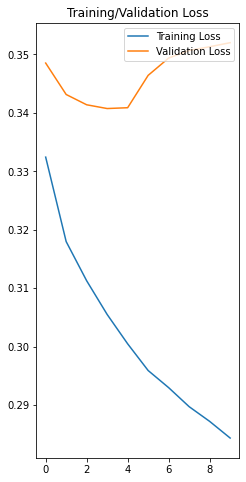

Epoch 1/10
33/33 [==============================] - 0s 5ms/step - loss: 0.3171 - mae: 0.2643 - rmse: 0.3235 - val_loss: 0.2664 - val_mae: 0.2164 - val_rmse: 0.3003
Epoch 2/10
33/33 [==============================] - 0s 3ms/step - loss: 0.3139 - mae: 0.2592 - rmse: 0.3167 - val_loss: 0.2489 - val_mae: 0.2010 - val_rmse: 0.2833
Epoch 3/10
33/33 [==============================] - 0s 3ms/step - loss: 0.2984 - mae: 0.2447 - rmse: 0.2980 - val_loss: 0.2370 - val_mae: 0.2004 - val_rmse: 0.2700
Epoch 4/10
33/33 [==============================] - 0s 3ms/step - loss: 0.2925 - mae: 0.2400 - rmse: 0.2899 - val_loss: 0.2339 - val_mae: 0.2007 - val_rmse: 0.2655
Epoch 5/10
33/33 [==============================] - 0s 4ms/step - loss: 0.2903 - mae: 0.2375 - rmse: 0.2856 - val_loss: 0.2381 - val_mae: 0.2027 - val_rmse: 0.2675
Epoch 6/10
33/33 [==============================] - 0s 4ms/step - loss: 0.2854 - mae: 0.2332 - rmse: 0.2790 - val_loss: 0.2431 - val_mae: 0.2049 - val_rmse: 0.2709
Epoch 7/10
33/33

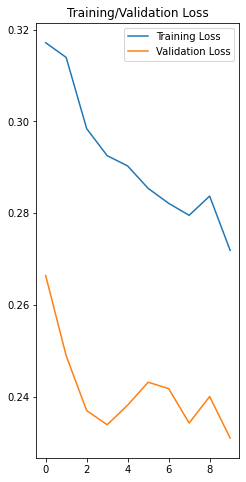

Epoch 1/10
49/49 [==============================] - 0s 4ms/step - loss: 0.3015 - mae: 0.2475 - rmse: 0.3050 - val_loss: 0.3648 - val_mae: 0.3135 - val_rmse: 0.3296
Epoch 2/10
49/49 [==============================] - 0s 3ms/step - loss: 0.2924 - mae: 0.2387 - rmse: 0.2947 - val_loss: 0.3531 - val_mae: 0.3005 - val_rmse: 0.3154
Epoch 3/10
49/49 [==============================] - 0s 3ms/step - loss: 0.2897 - mae: 0.2381 - rmse: 0.2917 - val_loss: 0.3573 - val_mae: 0.3048 - val_rmse: 0.3228
Epoch 4/10
49/49 [==============================] - 0s 3ms/step - loss: 0.2862 - mae: 0.2347 - rmse: 0.2875 - val_loss: 0.3533 - val_mae: 0.2989 - val_rmse: 0.3180
Epoch 5/10
49/49 [==============================] - 0s 3ms/step - loss: 0.2826 - mae: 0.2317 - rmse: 0.2834 - val_loss: 0.3532 - val_mae: 0.2964 - val_rmse: 0.3182
Epoch 6/10
49/49 [==============================] - 0s 3ms/step - loss: 0.2790 - mae: 0.2285 - rmse: 0.2790 - val_loss: 0.3540 - val_mae: 0.2939 - val_rmse: 0.3180
Epoch 7/10
49/49

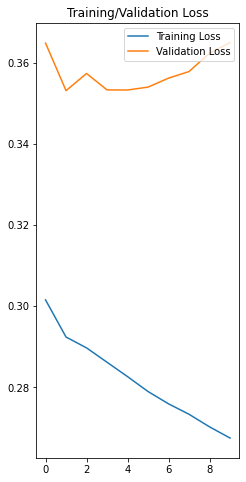

[[ 0.31353135 -0.18181818  0.2400151  -0.5780446 ]
 [ 0.5709571   0.27272727 -0.24200642 -0.8490566 ]
 [ 0.78437844  0.09090909  0.09365862 -0.94511149]
 [ 0.61056106  0.18181818 -0.38254314 -1.        ]
 [ 0.86578658  0.63636364 -0.36780857 -0.99313894]
 [ 0.94059406  0.18181818 -0.73486832 -0.96569468]
 [ 1.          0.09090909 -0.39180897 -0.73927959]]
1
[array([[18.505548]], dtype=float32)]


In [149]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

#Number os variables to use
n_variate = 4
#the dataframes
path=r'daily_diabetes.csv'
df_raw = load_dataset(path)
df_data = prepare_data(df_raw)
df = df_data.copy()

print(df.columns)

print(df.shape)

scaler = data_normalization(df) #scaling data to [-1, 1]


##Optimization

tunning_dict = {
                  1: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 }#,
                  #2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                  #3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                  #
                  #4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                  #5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                  #6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                  #
                  #7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                  #8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                  #9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

  }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)

   print(forecasts)

   prev = []

   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [150]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.291708246866862, 0.24027210772037508, 0.2928615649541219, 0.31519164294004437, 0.25944863706827165, 0.3160823414723078] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.291708,0.240272,0.292862,0.315192,0.259449,0.316082


In [151]:
#Results metrics to a file
final_df.to_csv(r"resultados_cnn_diabetes.csv",index=True)